In [21]:
import pandas as pd
from pandas.compat import StringIO
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [7]:
path='/home/wizard/Documents/observing_the_ocean/anna_wahlin/exercises/data/Exercise_3/'

In [67]:
import scipy.io as spio
import scipy
import numpy as np


def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [75]:
mat = loadmat(path+'S211.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'S211'])

In [79]:
mat['S211'].keys()

dict_keys(['in', 'out', 'lat', 'lon', 'depth', 'name', 'note', 'units', 'ins', 'sind', 'tind', 'pind', 'vind', 'oind', 'instrumentation', 'mat'])

In [78]:
mat['S211']['mat'].keys()

dict_keys(['time', 'u', 'mabv', 'v', 't', 'mabt', 's', 'mabs', 'p', 'mabp'])

Text(0.5,1,'Map showing location of mooring')

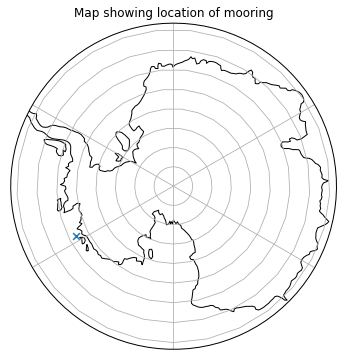

In [81]:
#plot location of mooring
import matplotlib.path as mpath

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

plt.figure(figsize=(6, 6))
ax = plt.axes(projection=ccrs.SouthPolarStereo())
ax.coastlines(resolution='110m')
ax.gridlines()
ax.set_extent([-180,180,-85,-65], ccrs.PlateCarree())
ax.scatter(mat['S211']['lon'],mat['S211']['lat'],
           transform=ccrs.PlateCarree(),
           marker='x',s=45)
ax.set_boundary(circle, transform=ax.transAxes)

plt.title('Map showing location of mooring')


In [109]:
#function to convert matlab datenum to python datetime

from datetime import datetime, timedelta

def datetimetodatenum(matlab_datenum):
    return (datetime.fromordinal(int(matlab_datenum)) + 
            timedelta(days=matlab_datenum%1) - timedelta(days = 366))

convert_dates = lambda matlab_datenum: datetimetodatenum(matlab_datenum)

#convert the dates
dates = np.array([convert_dates(xi) for xi in mat['S211']['mat']['time']])


### Plot timeseries of temperature and salinity

Text(0.5,0,'time')

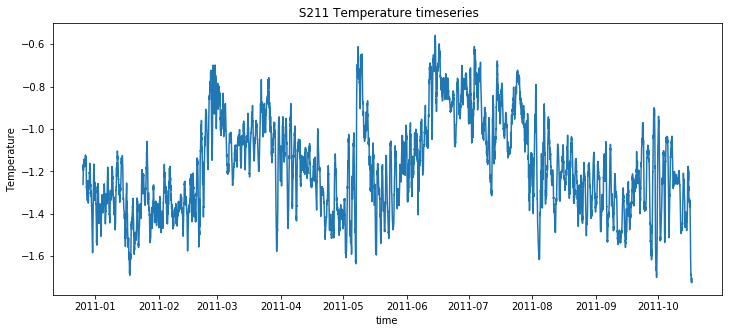

In [114]:
plt.figure(figsize=[12,5])
plt.title(' S211 Temperature timeseries')
plt.plot(dates,np.mean(mat['S211']['mat']['t'],axis=1))
plt.ylabel('Temperature')
plt.xlabel('time')

Text(0,0.5,'Salinity')

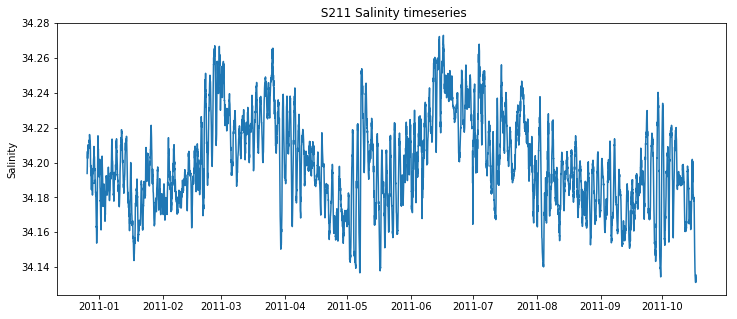

In [115]:
plt.figure(figsize=[12,5])
plt.title(' S211 Salinity timeseries')
plt.plot(dates,np.mean(mat['S211']['mat']['s'],axis=1))
plt.ylabel('Salinity')


### time series of velocity

Text(0,0.5,'U')

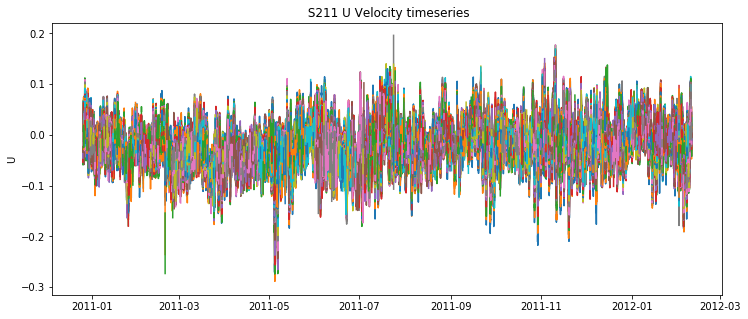

In [155]:
plt.figure(figsize=[12,5])
plt.title(' S211 U Velocity timeseries')
plt.plot(dates,mat['S211']['mat']['u'])
plt.ylabel('U')


Text(0,0.5,'V')

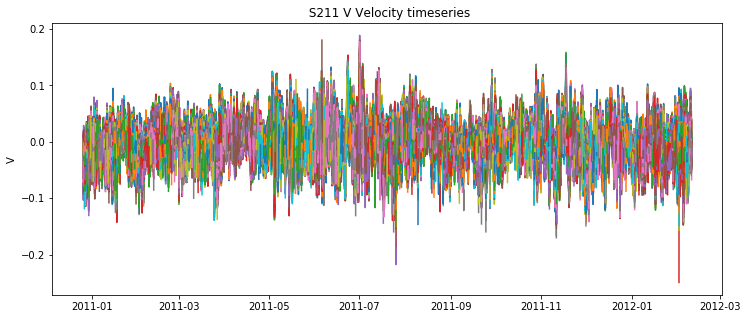

In [121]:
plt.figure(figsize=[12,5])
plt.title(' S211 V Velocity timeseries')
plt.plot(dates,mat['S211']['mat']['v'])
plt.ylabel('V')

/home/wizard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


Text(0,0.5,'U')

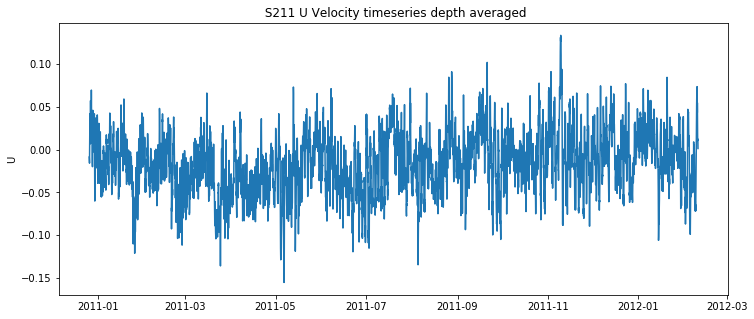

In [145]:
u_avg=np.nanmean(mat['S211']['mat']['u'],axis=1)


plt.figure(figsize=[12,5])
plt.title(' S211 U Velocity timeseries depth averaged')
plt.plot(dates,u_avg)
plt.ylabel('U')

/home/wizard/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


Text(0,0.5,'V')

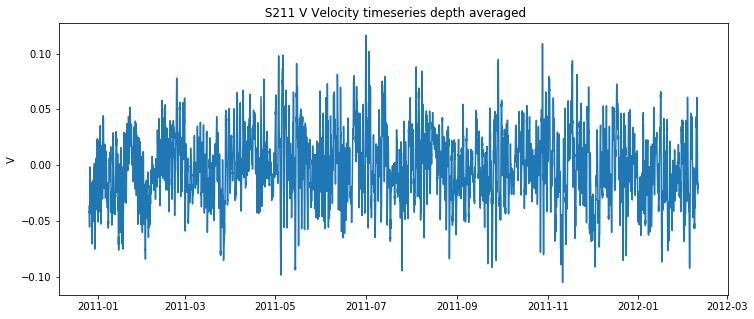

In [146]:
v_avg=np.nanmean(mat['S211']['mat']['v'],axis=1)
plt.figure(figsize=[12,5])
plt.title(' S211 V Velocity timeseries depth averaged')
plt.plot(dates,v_avg)
plt.ylabel('V')

In [128]:
# apply a fast fourier transform to the velocity data

/home/wizard/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


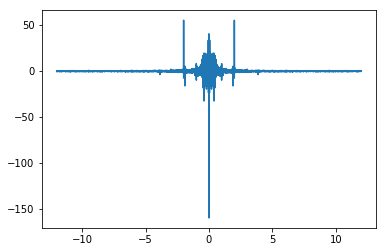

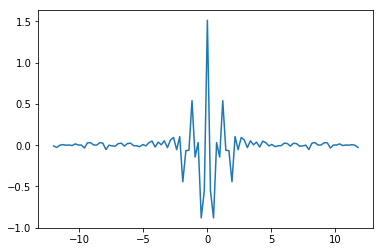

In [248]:
from scipy.fftpack import fft, ifft
v_avg.shape
#mask nans in dataset and interpolate over missing values - not the best solution????
mask = np.isfinite(u_avg)
xi = np.arange(len(u_avg))

ufiltered = np.interp(xi, xi[mask], u_avg[mask])
Fs=(np.asarray(mat['S211']['mat']['time'])[2]-
np.asarray(mat['S211']['mat']['time'])[1]) #sampling frequency 

#select L
L=len(mat['S211']['mat']['time']) #length of total signal
y = np.fft.fft(ufiltered,L)
#select full range
plt.figure()
freqs = np.fft.fftfreq(L, Fs)
idx = np.argsort(freqs)
plt.plot(freqs[idx], y[idx])

#select less
N=100 #set to 100
plt.figure()
y_less = np.fft.fft(ufiltered,N)
freqs = np.fft.fftfreq(N, Fs)
idx = np.argsort(freqs)
plt.plot(freqs[idx], y_less[idx])


Text(0.5,1,'Power spectrum (np.fft.fft)')

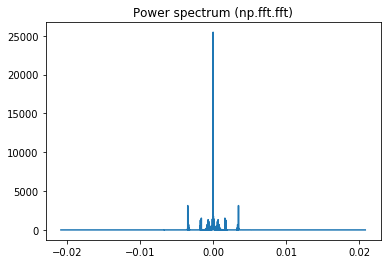

In [261]:
#compute power spectrum using complex composite
# Pyy=np.conj(y,L)
freqs = np.fft.fftfreq(L, 1/Fs)
idx = np.argsort(freqs)
ps = np.abs(np.fft.fft(ufiltered))**2
plt.figure()
plt.plot(freqs[idx], ps[idx])
plt.title('Power spectrum (np.fft.fft)')


Text(0,0.5,'PSD')

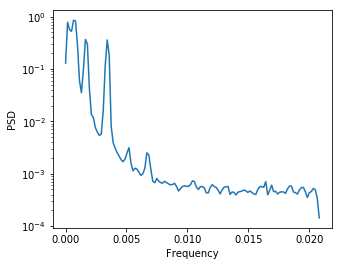

In [259]:
#compute power spectrum using scipy.welch
freqs, psd = signal.welch(ufiltered,Fs)
plt.figure(figsize=(5, 4))
plt.semilogy(freqs, psd)
plt.xlabel('Frequency')
plt.ylabel('PSD')

Text(0,0.5,'PSD')

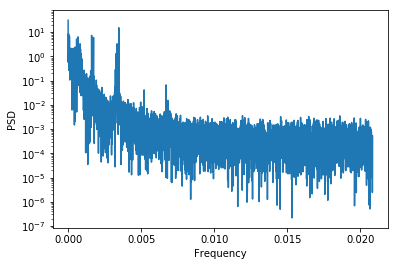

In [252]:
#power spectral density using periodogram
f, Pxx_den = signal.periodogram(ufiltered, Fs)
plt.semilogy(f[1:], Pxx_den[1:])
plt.xlabel('Frequency')
plt.ylabel('PSD')